Time Series Forecast with NHiTS on the Bellinge dataset

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar, StochasticWeightAveraging
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder

### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Bellinge/2_cleaned_data/G71F04R_Level2_iFixp3_proc_v6_short.csv')

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

# NaNs are not allowed by the model
data.fillna(0.0, inplace=True)

# One time series for every month?
#data['series'] = data['Datetime'].dt.year*12 + data['Datetime'].dt.month
#data['series'] -= data['series'].min()

# One time series for every 5 days?
#data['series'] = pd.Series([h for h in range(73) for _ in range(24*5)])

# One time series for the whole period?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,raw_value,level,series,time_idx
0,2020-10-12 00:00:00,0.000000,0.000000,0,0
1,2020-10-12 00:01:00,0.000000,0.000000,0,1
2,2020-10-12 00:02:00,0.000000,0.000000,0,2
3,2020-10-12 00:03:00,0.000000,0.000000,0,3
4,2020-10-12 00:04:00,0.000000,0.000000,0,4
...,...,...,...,...,...
54716,2020-11-18 23:56:00,0.148833,17.198833,0,54716
54717,2020-11-18 23:57:00,0.149333,17.199333,0,54717
54718,2020-11-18 23:58:00,0.148167,17.198167,0,54718
54719,2020-11-18 23:59:00,0.145333,17.195333,0,54719


In [3]:
# Create dataloaders
max_encoder_length = 60//2
max_prediction_length = 60//4
#training_cutoff = data["time_idx"].max() - max_prediction_length #20*max_prediction_length
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    target_normalizer="auto",
    time_idx="time_idx",
    target="level",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["raw_value", "level"],
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=18)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

### Training

In [4]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="gpu",
                     devices = 1,
                     max_epochs = 20,
                     gradient_clip_val=0.01,
                     logger = False)
net = NHiTS.from_dataset(training,
                          learning_rate=3e-2, weight_decay=1e-2,
                          backcast_loss_ratio=1.0)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 8.912509381337456e-05
Restoring states from the checkpoint path at /mnt/KInsektDaten/teo/.lr_find_763357ca-96ce-428f-8837-c24b69f804ef.ckpt
Restored all states from the checkpoint at /mnt/KInsektDaten/teo/.lr_find_763357ca-96ce-428f-8837-c24b69f804ef.ckpt


suggested learning rate: 8.912509381337456e-05


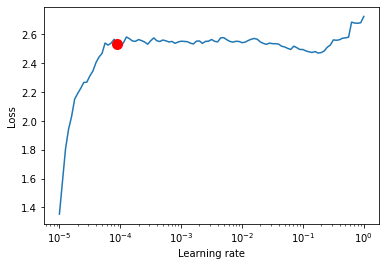

In [5]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net,
                             train_dataloaders=train_dataloader,
                             val_dataloaders=val_dataloader,
                             min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [6]:
pl.seed_everything(42)
early_stop = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_sched = StochasticWeightAveraging(swa_lrs=res.suggestion(), swa_epoch_start=5, device=torch.device('cuda:0'))
lr_logger = LearningRateMonitor(logging_interval='step')  # log the learning rate ('step' or 'epoch')
logger = TensorBoardLogger("./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge")  # logging results to a tensorboard
# at this path, a folder with the name lightning_logs is searched for; if not found, it is created

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop, lr_logger, TQDMProgressBar(), lr_sched],
    limit_train_batches=150,
    log_every_n_steps=5,
    logger=logger
)

net = NHiTS.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    #ckpt_path="./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge/lightning_logs/version_5/checkpoints/epoch=26-step=4050.ckpt"
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Restoring states from the checkpoint path at ./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge/lightning_logs/version_5/checkpoints/epoch=26

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.829


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.825


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.821


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.818


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<Figure size 432x288 with 0 Axes>

### Evaluation

In [7]:
trainer.callback_metrics

{'train_loss': tensor(3.5214, device='cuda:0'),
 'train_loss_step': tensor(3.5214, device='cuda:0'),
 'train_backcast_loss': tensor(0.1282, device='cuda:0'),
 'train_backcast_loss_step': tensor(0.1282, device='cuda:0'),
 'train_forecast_loss': tensor(3.5214, device='cuda:0'),
 'train_forecast_loss_step': tensor(3.5214, device='cuda:0'),
 'val_backcast_loss': tensor(0.1275, device='cuda:0'),
 'val_forecast_loss': tensor(2.8228, device='cuda:0'),
 'val_loss': tensor(2.8228, device='cuda:0'),
 'val_SMAPE': tensor(0.0002, device='cuda:0'),
 'val_MAE': tensor(0.0035, device='cuda:0'),
 'val_RMSE': tensor(0.0047, device='cuda:0'),
 'val_MAPE': tensor(0.0002, device='cuda:0'),
 'val_MASE': tensor(2.8228, device='cuda:0'),
 'train_loss_epoch': tensor(2.6526, device='cuda:0'),
 'train_backcast_loss_epoch': tensor(0.1286, device='cuda:0'),
 'train_forecast_loss_epoch': tensor(2.6526, device='cuda:0')}

In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NHiTS.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge/lightning_logs/version_8/checkpoints/epoch=44-step=6750.ckpt


In [9]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(0.0035, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


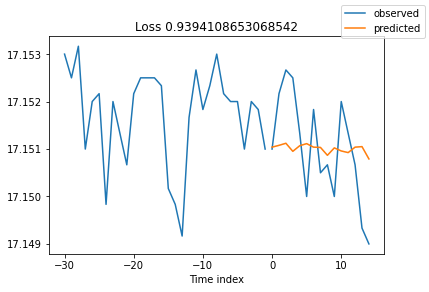

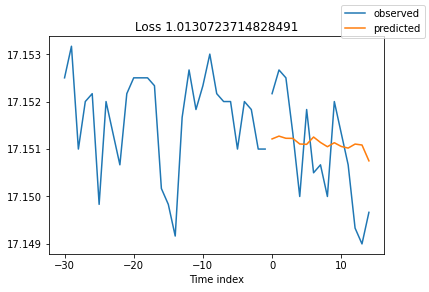

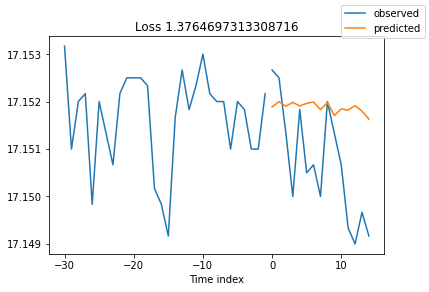

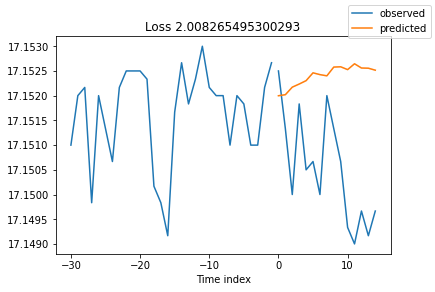

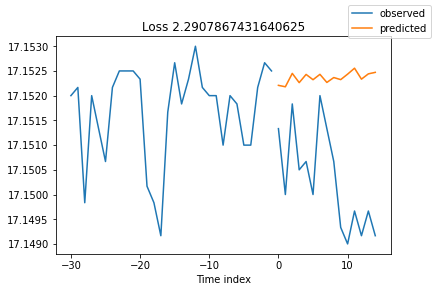

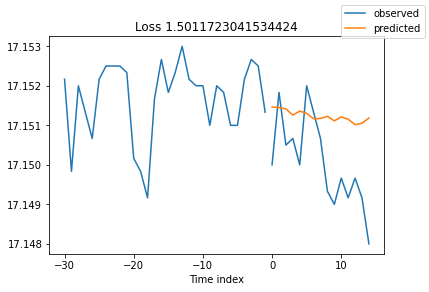

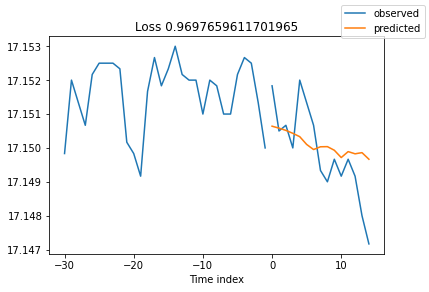

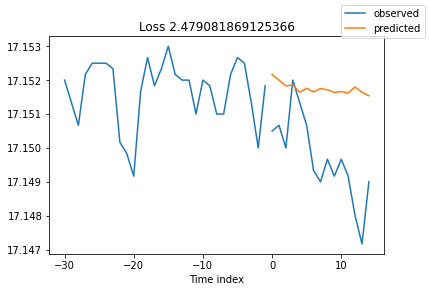

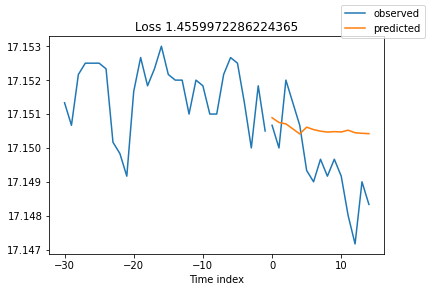

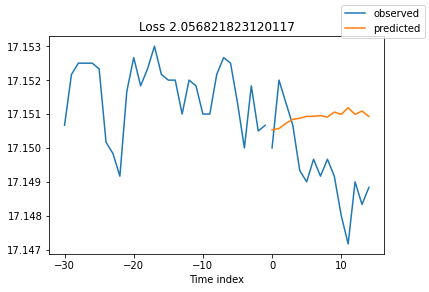

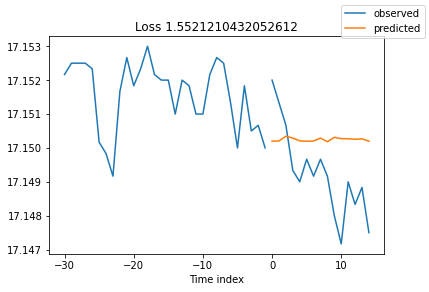

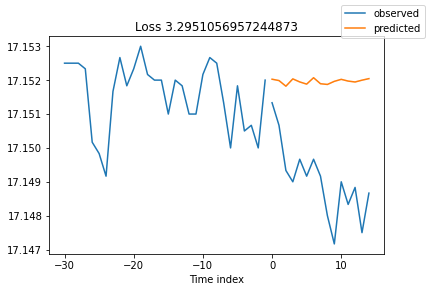

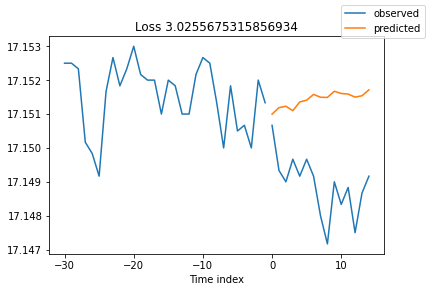

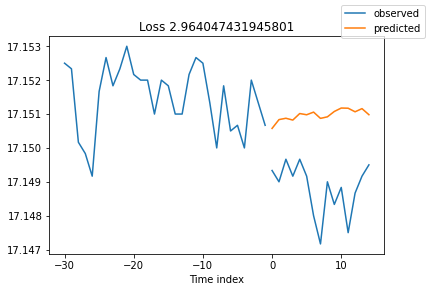

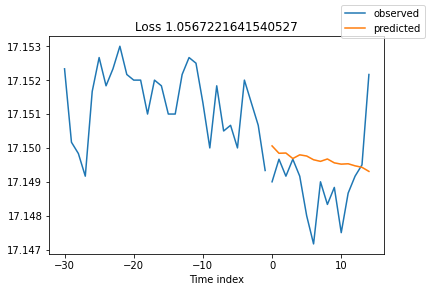

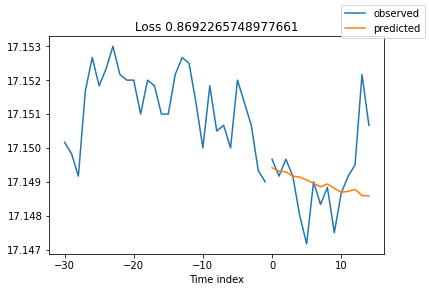

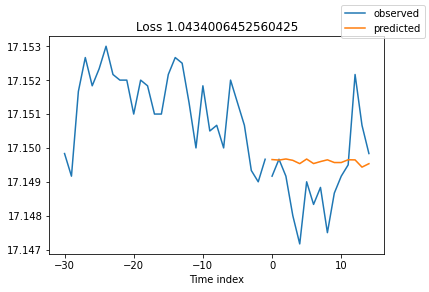

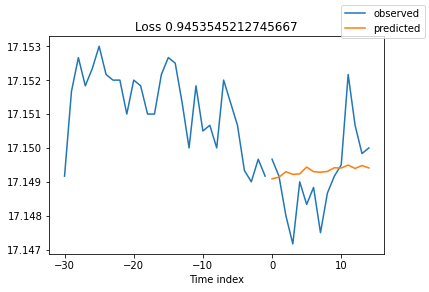

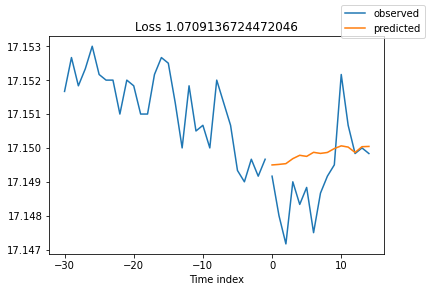

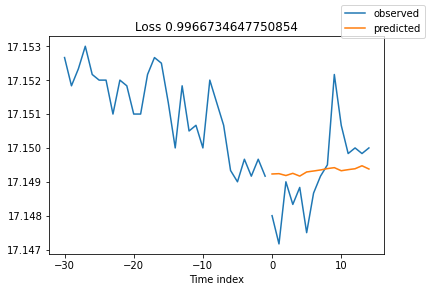

In [10]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Bellinge"))
for idx in range(20):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

In [11]:
#fig = best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=99, add_loss_to_title=True)

#### Interpretation

In [12]:
#fig = best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=99)

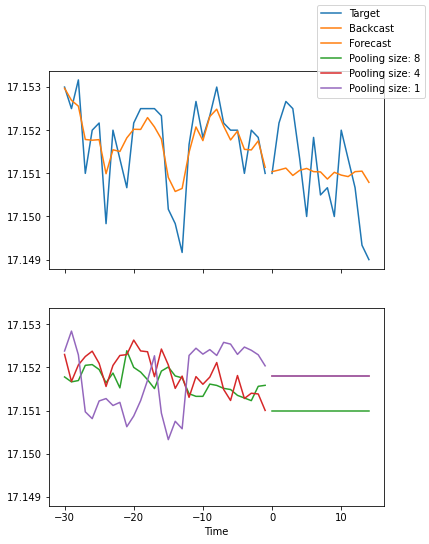

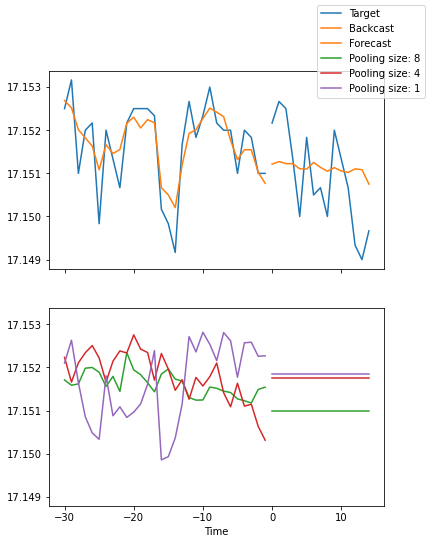

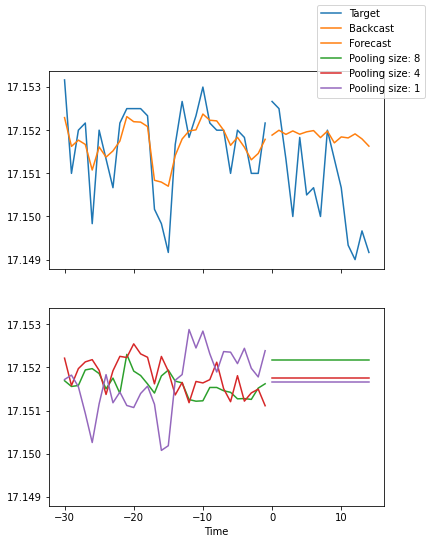

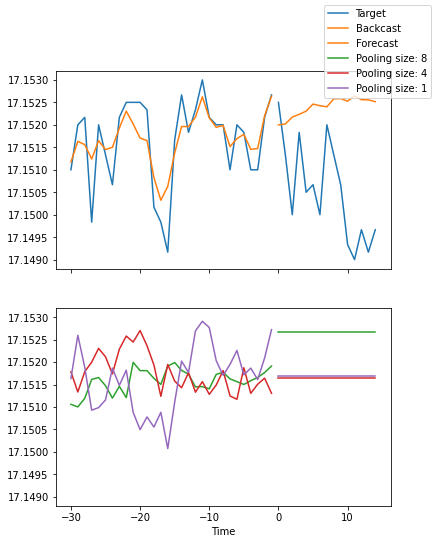

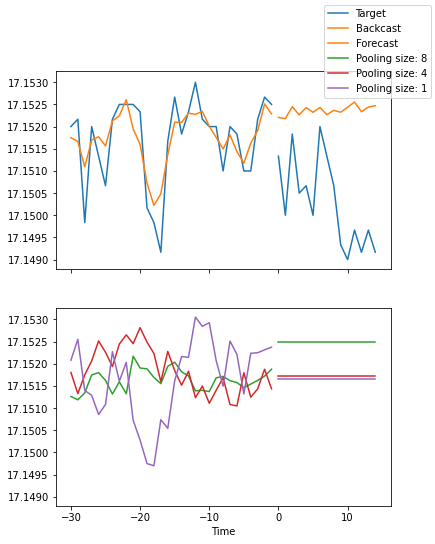

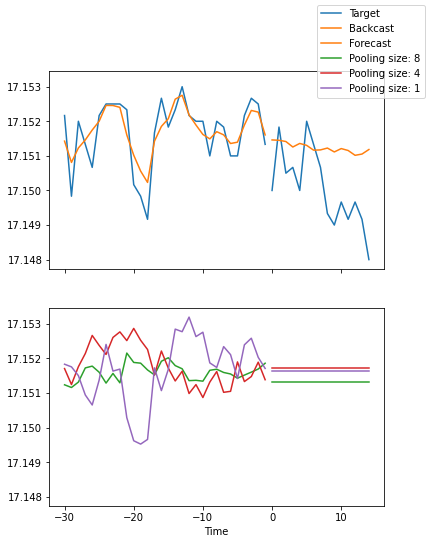

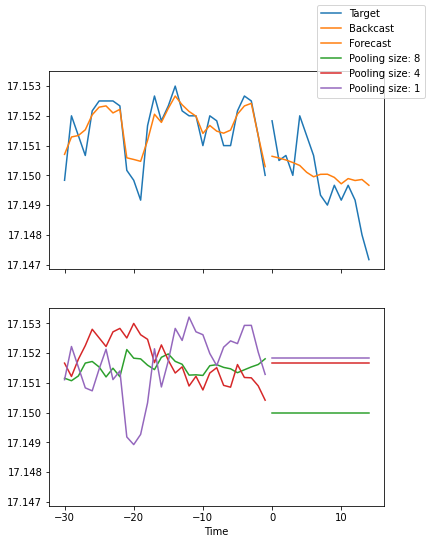

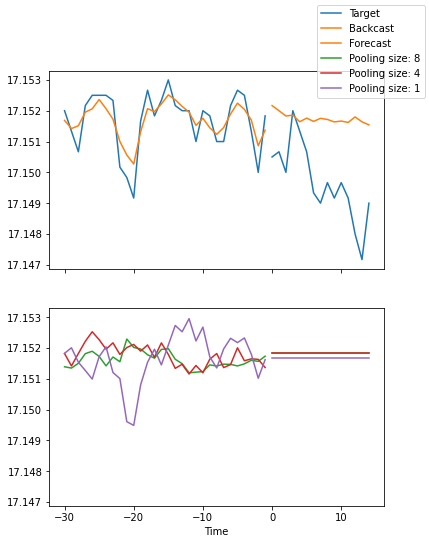

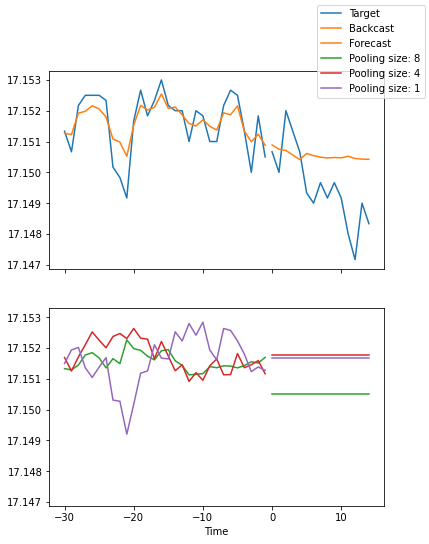

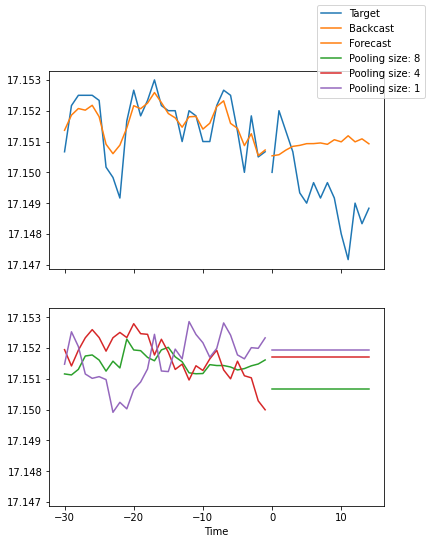

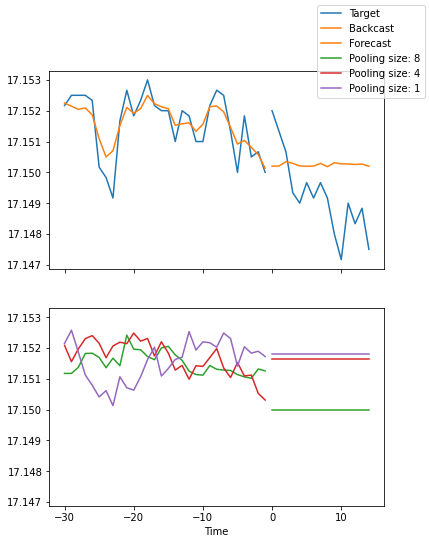

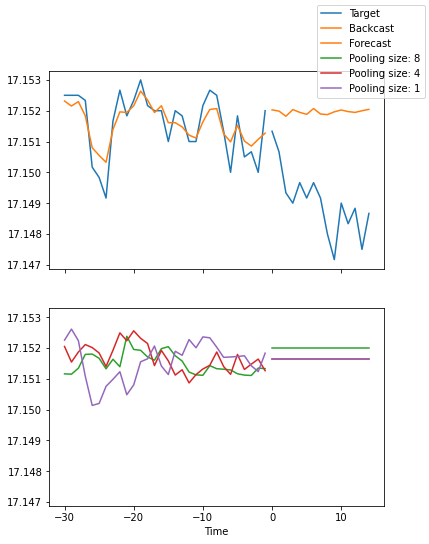

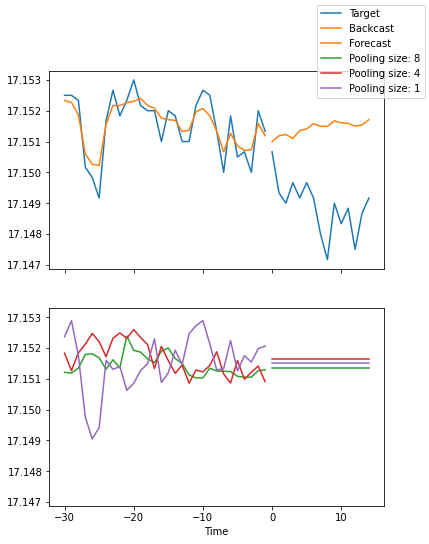

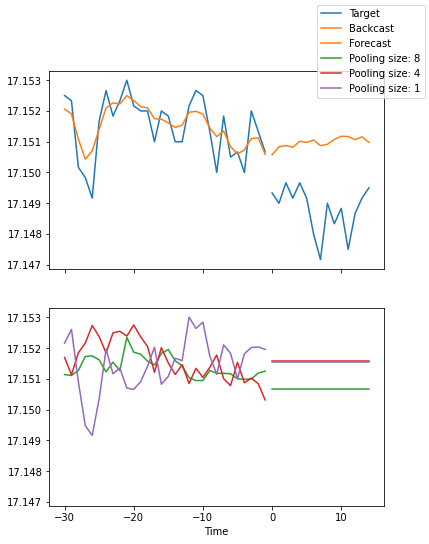

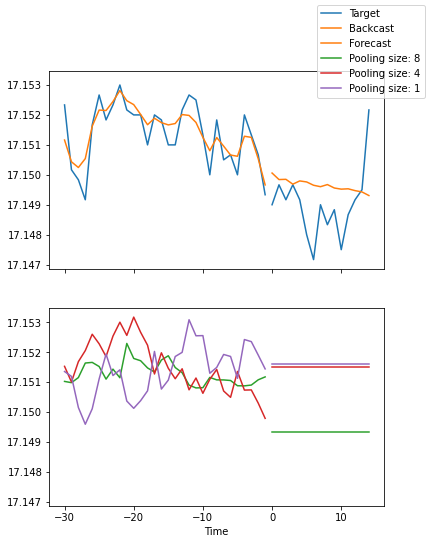

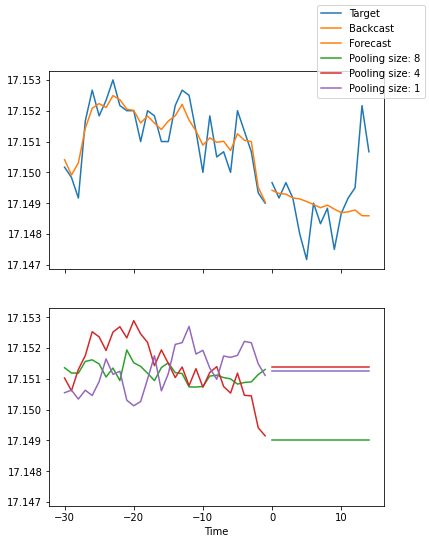

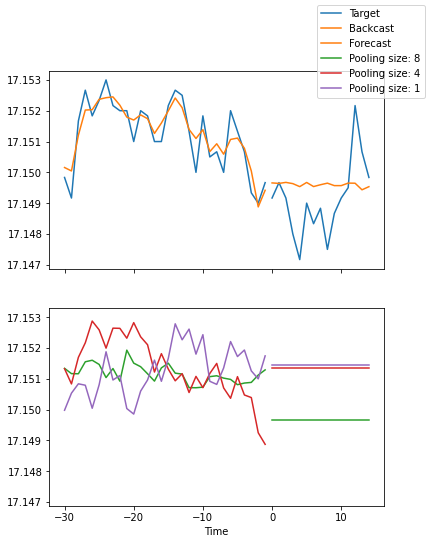

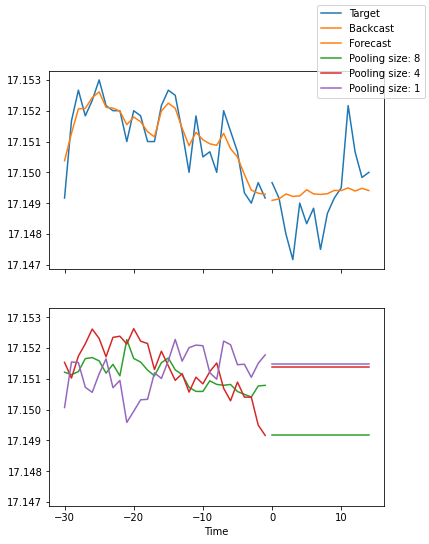

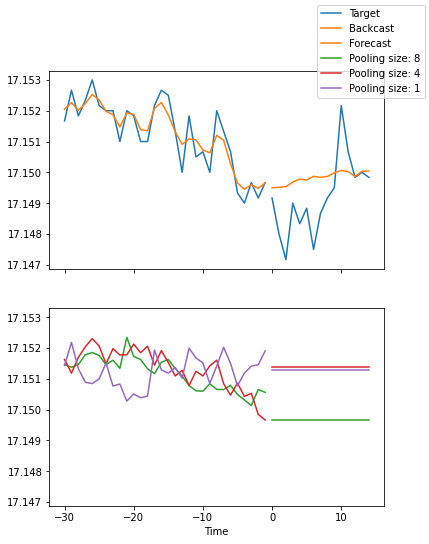

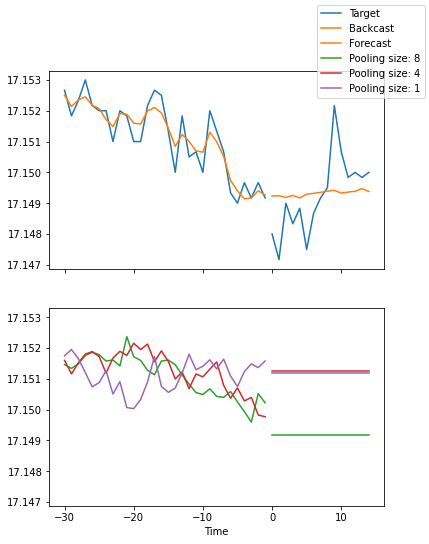

In [13]:
for idx in range(20):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)